In [1]:
import os

import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import set_matplotlib_formats

import jax.numpy as jnp
from jax import random

import numpyro
import numpyro.distributions as dist
from numpyro.contrib.control_flow import scan
from numpyro.diagnostics import autocorrelation, hpdi
from numpyro.infer import MCMC, NUTS, Predictive

if "NUMPYRO_SPHINXBUILD" in os.environ:
    set_matplotlib_formats("svg")

numpyro.set_host_device_count(4)

In [74]:
full_df = pd.read_csv('all_steps.csv')
sub_df = full_df[-365*24:-265*24]

data = sub_df.value

In [75]:
lynx = sub_df[['value']]
lynx['time'] = sub_df['date']

In [76]:
sub_df

,date,value
41969,2022-04-10 17:00:00,812
41970,2022-04-10 18:00:00,2786
41971,2022-04-10 19:00:00,1759
41972,2022-04-10 20:00:00,229
41973,2022-04-10 21:00:00,358
...,...,...
44364,2022-07-19 12:00:00,0
44365,2022-07-19 13:00:00,815
44366,2022-07-19 14:00:00,2067
44367,2022-07-19 15:00:00,15


In [80]:
def split_train_test(d, ratio=0.9):
    samples = int(len(d)*ratio)
    y_train = jnp.array(data[:samples], dtype=jnp.float32)
    y_test = jnp.array(data[samples:], dtype=jnp.float32)
    return y_train, y_test

y_train, y_test = split_train_test(data, ratio=0.9)

In [81]:
print("Split:")
print(f"  Training: {len(y_train)}")
print(f"  Testing : {len(y_test)}")

Split:
  Training: 2160
  Testing : 240


In [82]:
def sgt(y, seasonality, future=0):
    # heuristically, standard derivation of Cauchy prior depends on
    # the max value of data
    cauchy_sd = jnp.max(y) / 150

    # NB: priors' parameters are taken from
    # https://github.com/cbergmeir/Rlgt/blob/master/Rlgt/R/rlgtcontrol.R
    nu = numpyro.sample("nu", dist.Uniform(2, 20))
    powx = numpyro.sample("powx", dist.Uniform(0, 1))
    sigma = numpyro.sample("sigma", dist.HalfCauchy(cauchy_sd))
    offset_sigma = numpyro.sample(
        "offset_sigma", dist.TruncatedCauchy(low=1e-10, loc=1e-10, scale=cauchy_sd)
    )

    coef_trend = numpyro.sample("coef_trend", dist.Cauchy(0, cauchy_sd))
    pow_trend_beta = numpyro.sample("pow_trend_beta", dist.Beta(1, 1))
    # pow_trend takes values from -0.5 to 1
    pow_trend = 1.5 * pow_trend_beta - 0.5
    pow_season = numpyro.sample("pow_season", dist.Beta(1, 1))

    level_sm = numpyro.sample("level_sm", dist.Beta(1, 2))
    s_sm = numpyro.sample("s_sm", dist.Uniform(0, 1))
    init_s = numpyro.sample("init_s", dist.Cauchy(0, y[:seasonality] * 0.3))

    def transition_fn(carry, t):
        level, s, moving_sum = carry
        season = s[0] * level**pow_season
        exp_val = level + coef_trend * level**pow_trend + season
        exp_val = jnp.clip(exp_val, a_min=0)
        # use expected vale when forecasting
        y_t = jnp.where(t >= N, exp_val, y[t])

        moving_sum = (
            moving_sum + y[t] - jnp.where(t >= seasonality, y[t - seasonality], 0.0)
        )
        level_p = jnp.where(t >= seasonality, moving_sum / seasonality, y_t - season)
        level = level_sm * level_p + (1 - level_sm) * level
        level = jnp.clip(level, a_min=0)

        new_s = (s_sm * (y_t - level) / season + (1 - s_sm)) * s[0]
        # repeat s when forecasting
        new_s = jnp.where(t >= N, s[0], new_s)
        s = jnp.concatenate([s[1:], new_s[None]], axis=0)

        omega = sigma * exp_val**powx + offset_sigma
        y_ = numpyro.sample("y", dist.StudentT(nu, exp_val, omega))

        return (level, s, moving_sum), y_

    N = y.shape[0]
    level_init = y[0]
    s_init = jnp.concatenate([init_s[1:], init_s[:1]], axis=0)
    moving_sum = level_init
    with numpyro.handlers.condition(data={"y": y[1:]}):
        _, ys = scan(
            transition_fn, (level_init, s_init, moving_sum), jnp.arange(1, N + future)
        )
    if future > 0:
        numpyro.deterministic("y_forecast", ys[-future:])

In [83]:
def model(y, future=None):
    with numpyro.handlers.condition(data={"y": y[1:]}):
        _, ys = scan(
            transition_fn, (level_init, s_init, moving_sum), jnp.arange(1, N + future)
        )
    if future > 0:
        numpyro.deterministic("y_forecast", ys[-future:])

In [84]:
print("Lag values sorted according to their autocorrelation values:\n")
print(jnp.argsort(autocorrelation(y_train))[::-1])

Lag values sorted according to their autocorrelation values:

[2158 2157    0 ... 2154 2155 2156]


In [85]:
%%time

seasonality = 24

kernel = NUTS(sgt)
mcmc = MCMC(kernel, num_warmup=2000, num_samples=4000, num_chains=4)
mcmc.run(random.PRNGKey(100), y_train, seasonality=seasonality)
mcmc.print_summary()
samples = mcmc.get_samples()


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                      mean       std    median      5.0%     95.0%     n_eff     r_hat
      coef_trend     -0.64      1.00     -0.71     -1.99      0.83       nan 3511314.33
       init_s[0]      0.01      0.90      0.25     -1.44      0.96      2.00 114907.17
       init_s[1]     -0.90      0.98     -0.94     -1.93      0.20      2.00  32835.02
       init_s[2]      0.06      0.76     -0.32     -0.49      1.38      2.00  56101.69
       init_s[3]      0.17      1.10      0.40     -1.35      1.23      2.00  76795.01
       init_s[4]      0.10      1.28     -0.04     -1.42      1.90      2.00  63829.25
       init_s[5]      0.44      1.37      0.95     -1.85      1.72      2.00  52715.94
       init_s[6]     -0.43      1.12     -0.23     -1.99      0.72      2.00  71935.81
       init_s[7]     -0.42      0.94     -0.12     -1.99      0.54      2.00  58724.88
       init_s[8]      0.07      1.09      0.19     -1.58      1.47      2.00  99783.38
       init_s[9]     -0.55      1.05     

In [87]:
predictive = Predictive(sgt, samples, return_sites=["y_forecast"])
forecast_marginal = predictive(random.PRNGKey(1), y_train, seasonality=seasonality, future=len(y_test))[
    "y_forecast"
]


In [88]:
y_pred = jnp.mean(forecast_marginal, axis=0)
sMAPE = jnp.mean(jnp.abs(y_pred - y_test) / (y_pred + y_test)) * 200
msqrt = jnp.sqrt(jnp.mean((y_pred - y_test) ** 2))
print("sMAPE: {:.2f}, rmse: {:.2f}".format(sMAPE, msqrt))



sMAPE: nan, rmse: nan


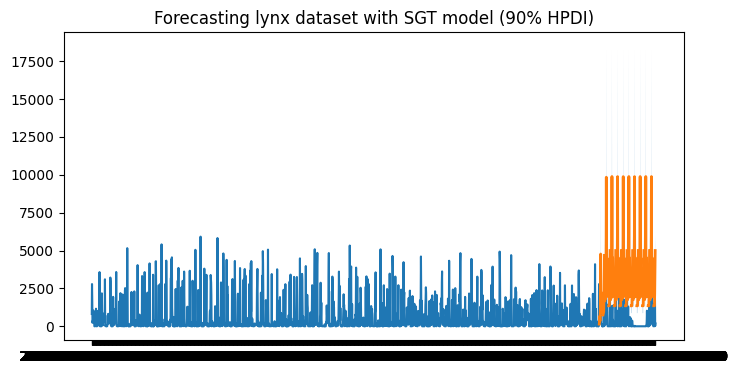

In [89]:
plt.figure(figsize=(8, 4))
plt.plot(lynx["time"], data)
t_future = lynx["time"][len(y_train):]
hpd_low, hpd_high = hpdi(forecast_marginal)
plt.plot(t_future, y_pred, lw=2)
plt.fill_between(t_future, hpd_low, hpd_high, alpha=0.3)
plt.title("Forecasting lynx dataset with SGT model (90% HPDI)")
plt.show()